In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rounding = "round"):
    in_feature = 1024
    out_feature = 1024
    bias = True

    input = (torch.rand(256, in_feature) - 0.5).to(device)

    fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
    fc_o = fc(input)
    
    ufc_err_min_list = []
    ufc_err_max_list = []
    ufc_err_mean_list = []
    ufc_err_std_list = []

    ffc_err_min_list = []
    ffc_err_max_list = []
    ffc_err_mean_list = []
    ffc_err_std_list = []
    
    x_label = []
    
    for bitwidth in range(6, 13): 
        cycle = 2**(bitwidth-1)

        ufc = HUBLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, cycle=cycle, rounding=rounding).to(device)
        ufc_o = ufc(input)

        ffc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, rounding=rounding).to(device)
        ffc_o = ffc(input)

        ufc_err = (ufc_o - fc_o)
        ffc_err = (ffc_o - fc_o)
        
        ufc_err_min_list.append(ufc_err.min().item())
        ufc_err_max_list.append(ufc_err.max().item())
        ufc_err_mean_list.append(ufc_err.mean().item())
        ufc_err_std_list.append(ufc_err.std().item())
        
        ffc_err_min_list.append(ffc_err.min().item())
        ffc_err_max_list.append(ffc_err.max().item())
        ffc_err_mean_list.append(ffc_err.mean().item())
        ffc_err_std_list.append(ffc_err.std().item())
        
        x_label.append(2**(bitwidth-1))
        
    return ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ffc_err_min_list, ffc_err_max_list, ffc_err_mean_list, ffc_err_std_list, x_label


In [5]:
rounding = "round"
ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ffc_err_min_list, ffc_err_max_list, ffc_err_mean_list, ffc_err_std_list, x_label = test(rounding)
print(ufc_err_min_list)
print(ufc_err_max_list)
print(ufc_err_mean_list)
print(ufc_err_std_list)

print(ffc_err_min_list)
print(ffc_err_max_list)
print(ffc_err_mean_list)
print(ffc_err_std_list)

print(x_label)

[-0.07429313659667969, -0.03614455461502075, -0.019196927547454834, -0.01001158356666565, -0.005250394344329834, -0.0026258230209350586, -0.0013356804847717285]
[0.07491174340248108, 0.03795558214187622, 0.02048516273498535, 0.010170221328735352, 0.005152285099029541, 0.0023808181285858154, 0.001274406909942627]
[1.591140971868299e-06, 1.8851344066206366e-05, 7.403800736938138e-07, 3.4379579574306263e-06, 1.5126818198041292e-06, 5.355157099984353e-07, -5.543049041989434e-07]
[0.016615785658359528, 0.008474224247038364, 0.004320206586271524, 0.0022005923092365265, 0.0011180703295394778, 0.0005700456094928086, 0.0002945158048532903]
[-0.01759597659111023, -0.007970273494720459, -0.0050785839557647705, -0.0021648481488227844, -0.0010089278221130371, -0.0005868040025234222, -0.00024771690368652344]
[0.017973244190216064, 0.008413687348365784, 0.004163585603237152, 0.0019758939743041992, 0.00101422518491745, 0.0005729794502258301, 0.00022971630096435547]
[1.346646786259953e-05, -7.213250682

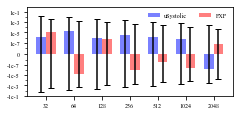

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'family':'Times New Roman', 'size': 6}

matplotlib.rc('font', **font)

my_dpi = 300
fig_h = 1.6
fig_w = 3.3115

# construct some data like what you have:
x = np.array([i for i in range(len(ufc_err_mean_list))])
means1 = np.array(ufc_err_mean_list)
stds1 = np.array(ufc_err_std_list)
mins1 = np.array(ufc_err_min_list)
maxs1 = np.array(ufc_err_max_list)
means2 = np.array(ffc_err_mean_list)
stds2 = np.array(ffc_err_std_list)
mins2 = np.array(ffc_err_min_list)
maxs2 = np.array(ffc_err_max_list)
x_label = np.array(x_label)

width = 0.35
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.bar(x-width/2, means1, width, yerr=stds1, align='center', alpha=1, capsize=3, color="#7A81FF", label="uSystolic")
ax.bar(x+width/2, means2, width, yerr=stds2, align='center', alpha=1, capsize=3, color="#FF7F7F", label="FXP")
ax.set_xticks(x)
ax.set_xticklabels(x_label)

ax.set_yscale('symlog', linthresh=10**(-8))
ax.set_ylim(-0.1, 0.99)
ax.set_yticks([-10**(-1), -10**(-3), -10**(-5), -10**(-7), 0, 10**(-7), 10**(-5), 10**(-3), 10**(-1)])
# ax.set_yticklabels([-10**(-2), -10**(-4), -10**(-6), -10**(-8), 0, 10**(-8), 10**(-6), 10**(-4), 10**(-2)])
ax.set_yticklabels(["-1e-1", "-1e-3", "-1e-5", "-1e-7", "0", "1e-7", "1e-5", "1e-3", "1e-1"])
ax.legend(loc="upper right", ncol=2, frameon=False)

fig.tight_layout()
plt.show()
fig.savefig("test_kernel_linear_fxp_hub_compare.pdf", bbox_inches='tight', dpi=my_dpi)
